# 论文名：Universal quantum state preparation via revised greedy algorithm 
## 论文链接：https://arxiv.org/pdf/2108.03351.pdf 

## 项目介绍：

   原论文提出一种改进版的贪心算法 (Revised Greedy Algorithm) 可以根据实际物理系统的硬件限制，设计最佳控制脉冲，以实现任意单或双量子比特态之间的相互制备。本项目基于 Mindquantum 量子计算框架对其算法和核心结果进行复现，对原代码进行优化整合，以实现在社区上更好的开源效果及算法推广 。

## 论文介绍
   ### 摘要：
   
   量子计算机需要具备对任意量子态的制备能力。比如，在运行量子算法之前需要先通过适当的控制将量子比特制备到基态（或者指定的其他任意叠加态）。控制脉冲的设计要遵守实际物理系统的硬件限制。比如，在半导体单-三重态编码的双量子点系统的控制中，唯一可控的变量是通过电压调制的两个电子之间的耦合强度，而磁场强度一直存在但很难改变。反映到布洛赫球表示上，即是量子态只有沿 $z$ 轴方向的旋转速度可调，而绕 $x$ 轴的旋转速度为非 0 的常值。常规的优化算法，如 GRAPE 和 CRAB 受控制脉冲初猜值的影响很大，运行效果不够稳定，且效率较低，而新兴的机器学习算法则需要过多的训练，计算成本很大。本文基于优化算法中常见的贪心算法 (Greedy Algorithm) 提出一个改进版本。计算结果表明，无论是在量子态制备的保真度、控制脉冲数量还是算法效率上，都要优于 GRAPE 和 CRAB 算法。相比机器学习，则完全不需要任何训练过程。
   
   ### 正文梗概： 
   
   得益于量子干涉和量子叠加等量子特性，量子计算机能够解决一些在经典计算机上很难甚至根本无法解决的问题。在过去的几十年里，从单个电子自旋到拓扑系统，为实现量子计算，科学家提出了各种各样量子系统，并在实验中进行了证实。随着硬件系统的快速发展，对量子系统进行最优化控制的问题求解也迫在眉睫。
   
   在线路量子计算模型中，结合任意单量子比特门和任意一个双量子比特纠缠门，可以执行任意的逻辑操作。但任意单量子比特门的执行需要被编译成“原生门”才能在物理系统上执行。将任意单量子比特门根据底层硬件的特性进行优化编译是一个很重要的优化问题。单量子比特门的实行和量子态制备具有内在一致性，本文即以参数严重受限的半导体双量子点中单-三重态编码量子比特和超导线路模型量子比特的态制备最佳控制问题为例来介绍一种新的优化算法。
   
   动态规划是一种重要的优化思想，其将一个大而复杂的问题拆解成为多个小而简单的子问题并分别予以求解，众多子问题的解结合在一起即是所求问题的最终解。贪心算法是动态规划中常见的一种算法，其动作选择策略是直接选择子问题的最佳动作。但单纯采用贪心算法容易陷入局部最优，比如，在量子态制备问题中，假设目标态为位于布洛赫球北极的 $|0\rangle$，而当量子态位于赤道上的叠加态上时，当前时刻的最佳动作可能是继续沿着赤道旋转，从而永远不能到达目标点。
    
   本文提出一种改进的贪心算法，其基本思想是当控制陷入局部最优时，采用不同的非最优动作，以期跳出局部最优，最终达到全局最优。这一思想是优化算法领域中常用的一种策略。关键点在于如何断定控制是否陷入了局部最优。本文采用保真度验证法：如果采用当前最佳动作导致的下一时刻的保真度低于上一时刻的保真度，即判定为陷入局部最优，进而采用非最优动作。
   
   算法为：
   
   （1）选定初态和目标态，并从初态开始，根据保真度执行当前时刻最佳动作；
   
   （2）根据下一时刻保真度判断是否陷入局部最优。
   
          1. 当控制未陷入局部最优时，采用常规的贪心算法——直接选择当前时刻最佳动作；
         
          2. 当控制陷入局部最优时，分别执行三种策略：
          
             1. 依然采用当前时刻最佳动作；
             
             2. 采用次优动作，以最小代价脱离局部最优；
             
             3. 采用最差动作，以最大程度远离局部最优点。
             
   （3）重复执行策略及动作，直到保真度达到要求或控制步数超过最大允许值。
   
   （4）选择最终保真度最高的策略所对应的控制方案。
 
   


安装所需依赖项

In [ ]:
!pip install --upgrade pip
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/1.5.0/MindSpore/cpu/x86_64/mindspore-1.5.0-cp37-cp37m-linux_x86_64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install https://hiq.huaweicloud.com/download/mindquantum/newest/linux/mindquantum-master-cp37-cp37m-linux_x86_64.whl -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install scipy 
!pip install numpy
!pip install matplotlib 

# 1. 复现半导体双量子点单-三重态编码量子比特系统的任意量子态制备任务
 
环境准备：导入本项目所依赖模块

In [3]:
from mindquantum import *
import matplotlib.pyplot as plt
from scipy.linalg import expm
from time import *
import numpy as np
from src import USP_qd_single_qubit # 论文主程序

设置图片显示格式

In [4]:
%matplotlib inline

设置 “随机数种子” 

In [ ]:
np.random.seed(1) # 设置随机数种子，使算法表现稳定

设置 脉冲控制参数、泡利算符和动作空间

In [ ]:
T = 2*np.pi # 最大演化时间
dt = np.pi/5 # 时间步长
step_max = T/dt # 最大控制脉冲数

sx = X.matrix() # 定义泡利算符，根据 mindquantum 基本门的 matrix() 功能来得到矩阵形式  
sy = Y.matrix() 
sz = Z.matrix()

action_space = np.array([[0],[1],[2],[3]]) # 离散动作空间

设置初始和目标量子态集合。两个点集相同，都有128个采样点，关于布洛赫球角度几乎均匀分布，目标是实现这128个点之间的相互制备，从而体现出普适特性。

In [ ]:
theta_num = 6 # 除了 0 和 Pi 两个点之外，点的数量
varphi_num = 21 # varphi 角度一圈上的点数
#总点数为 theta_num * varphi_num + 2(布洛赫球两极) 此处共 128 个点

theta = np.linspace(0,np.pi,theta_num+2,endpoint=True) 
varphi = np.linspace(0,np.pi*2,varphi_num,endpoint=False) 

def psi_set():
    psi_set = []
    for ii in range(1,theta_num+1):
        for jj in range(varphi_num):
            psi_set.append(np.array([np.cos(theta[ii]/2),np.sin(theta[ii]/2)*(np.cos(varphi[jj])+np.sin(varphi[jj])*(0+1j))]))
            
    psi_set.append(np.array([1,0])) # 最后再加上 |0> 和 |1> 两个态
    psi_set.append(np.array([0,1]))
    return psi_set

target_set = psi_set() # 目标量子态集
init_set = psi_set() # 初始量子态集

在陷入局部最优时，根据下一时刻的保真度，采用上文提到的三种动作选择策略。

半导体双量子点中单-三重态编码的单量子比特的哈密顿量定义为： $$H=J(t)\sigma_z+h\sigma_x,$$ 其中 $J(t)$ 即为动作值，而 $h$ 为固定值，此处设为 1，并将其作为动作的单位。将约化普朗克常数 $\hbar$ 设为 1，并将 $1/\hbar$ 作为时间标度。

量子态的保真度定义为： $$F=|\langle s_{next} | s_{target}\rangle|^2.$$
时间演化算符为：$$\exp{(-iH\mathrm{d}t)}.$$

三种策略都返回各自对应的动作、下一时刻保真度、和下一时刻的量子态。

先设置时间演化算符 和 作用该算符的线路 

In [ ]:
def _matrix(coeff):
    return expm(-1j*(coeff*sz+sx)*dt)

def _diff_matrix(coeff):
    return -1j*dt*_matrix(coeff)@sz

Evo = gene_univ_parameterized_gate('U', _matrix, _diff_matrix) # 给定动作的时间演化算符
circ = Circuit()+Evo('coeff').on(0) # 将时间演化算符作为量子门编到线路中
ham = Hamiltonian(QubitOperator("")) # 定义一个空的哈密顿量，用于后面求解两个量子态之间的保真度

设置动作选择策略：

In [ ]:
# 动作选择策略 0：选择下一时刻量子态保真度更高所对应的那个动作
def step0(sim, sim_target, F): # 这里 F 就没啥用了，只是为了和其他两种策略比齐
    fid_ops = sim.get_expectation_with_grad(ham, # 单位算符，除了占位，啥用也没有。因为要计算的是两个量子态之间的保真度
                                            circ, # 右线路，由时间演化算符所定义。用于根据当前时刻量子态计算下一时刻量子态
                                            Circuit(), # 左线路，空的。保持目标态不变
                                            sim_target, # 目标量子态
                                            encoder_params_name=['coeff'], # 调入动作值
                                            parallel_worker=1) # 并行核
    
    fid_list, _ = fid_ops(action_space) # np.array([[0],[1],[2],[3]]) 每一行作为一个样本
    fid_list = np.squeeze(np.abs(fid_list)**2)
    
    best_action = np.argmax(fid_list)  
    best_fid = fid_list[best_action]
    
    sim.apply_circuit(circ,pr=best_action)
    psi_ = sim.get_qs()
    
    return best_action, best_fid, psi_

#------------------------------------------------------------------------------------------------------------------------
# 动作选择策略 1：要么选最优动作，要么选最差的动作
def step1(sim, sim_target, F): # F 作为判断控制是否陷入局部最优，如果各动作中没有比 F 更高的保真度，就意味着陷入了局部最优
    fid_ops = sim.get_expectation_with_grad(ham, # 单位算符，除了占位，啥用也没有。因为要计算的是两个量子态之间的保真度
                                            circ, # 右线路，由时间演化算符所定义。用于根据当前时刻量子态计算下一时刻量子态
                                            Circuit(), # 左线路，空的。保持目标态不变
                                            sim_target, # 目标量子态
                                            encoder_params_name=['coeff'], # 调入动作值
                                            parallel_worker=1) # 并行核
    

    fid_list, _ = fid_ops(action_space) # np.array([[0],[1],[2],[3]]) 每一行作为一个样本
    fid_list = np.squeeze(np.abs(fid_list)**2)
    
    if F < max(fid_list): # 如果没有陷入局部最优，就直接选择最大保真度对应的动作
        best_action = np.argmax(fid_list)
        best_fid = fid_list[best_action]
        
    else: # 否则选择最差的动作，以最大程度跳出局部最优
        best_action = np.argmin(fid_list)
        best_fid = fid_list[best_action]
        
    sim.apply_circuit(circ,pr=best_action)
    psi_ = sim.get_qs()
        
    return best_action, best_fid, psi_

#------------------------------------------------------------------------------------------------------------------------
# 动作选择策略 2：要么选最优动作，要么选次优的动作
def step2(sim, sim_target, F): # F 作为判断控制是否陷入局部最优，如果各动作中没有比 F 更高的保真度，就意味着陷入了局部最优
    fid_ops = sim.get_expectation_with_grad(ham, # 单位算符，除了占位，啥用也没有。因为要计算的是两个量子态之间的保真度
                                            circ, # 右线路，由时间演化算符所定义。用于根据当前时刻量子态计算下一时刻量子态
                                            Circuit(), # 左线路，空的。保持目标态不变
                                            sim_target, # 目标量子态
                                            encoder_params_name=['coeff'], # 调入动作值
                                            parallel_worker=1) # 并行核
    
    fid_list, _ = fid_ops(action_space) # np.array([[0],[1],[2],[3]]) 每一行作为一个样本
    fid_list = np.squeeze(np.abs(fid_list)**2)
    
    if F < max(fid_list): # 如果没有陷入局部最优，就直接选择最大保真度对应的动作
        best_action = np.argmax(fid_list)
        best_fid = fid_list[best_action]
        
    else: # 否则选择最差的动作，以最小代价跳出局部最优
        fid_list[np.argmax(fid_list)] = 0 # 将最大保真度故意赋值为 0
        best_action = np.argmax(fid_list) # 那么再对保真度列表求一次最大值，就是实际上的次最大值了
        best_fid = fid_list[best_action] 
    
    sim.apply_circuit(circ,pr=best_action)
    psi_ = sim.get_qs()
        
    return best_action, best_fid, psi_

程序主函数：计算量子态相互制备的保真度。得到128个目标态的平均保真度，其中每个目标态由其他127个初态开始制备。

In [ ]:
def job(target_set): # 输入为一个128个采样点的目标态集合。
                     # 每个目标态target_psi都由初始态集中的初态制备

    F_list = [] # 用于记录制备所有目标态的平均保真度
    count = 0 # 用于监测程序执行进度，达到128时即完成
    
    sim = Simulator('projectq', 1) 
    sim_target = Simulator('projectq', 1)
     
    for target_psi in target_set:
        print(count)
        count += 1

        sim_target.set_qs(target_psi) # 设置目标量子态
        fids_list = [] # 用于记录所有初始态制备本目标态中目标态的保真度
        
        number = 0
        for psi1 in init_set: # 对初始态集合中的每个初始态进行遍历执行
            print(number)
            number += 1
            
            sim.set_qs(psi1) # 设置当前时刻量子态
            fid_ops = sim.get_expectation_with_grad(ham, # 单位算符，除了占位，啥用也没有。因为要计算的是两个量子态之间的保真度
                                                    Circuit(), # 右线路，空的。保持当前量子态不变
                                                    Circuit(), # 左线路，空的。保持目标态不变
                                                    sim_target) # 目标量子态
            fid, _ = fid_ops(np.array([])) # 调用函数
            F = np.squeeze((np.abs(fid)**2)) # 先计算一下初始态的保真度，以便与下一时刻的保真度进行比较，以判断是否陷入局部最优
        
            fid_max = F # 每个策略分开执行
            fid_max1 = F
            fid_max2 = F
            fid_max0 = F
            
            # 执行策略 1：选 最佳动作 或 次优动作
            step_n = 0 # 计算控制脉冲数
            while True: 
                action, F, psi_ = step1(sim, sim_target, F) # 采用策略 1 来确定动作、下一时刻的保真度 和 下一时刻量子态
                fid_max1 = max(F,fid_max1) # 记录此策略下能达到的最大保真度，用于判定效果和截取控制脉冲序列。
                psi = psi_ # 迭代量子态
                step_n += 1
                if fid_max1>0.999 or step_n>step_max: # 当保真度大于阈值0.999或总步数超过限制就终止循环
                    break
                
            # 与上面类似的操作，执行的是策略 2：选最佳动作 或 最差动作   
            step_n = 0 
            sim.set_qs(psi1) # 设置当前时刻量子态
            fid_ops = sim.get_expectation_with_grad(ham, Circuit(),  Circuit(), sim_target)
            fid, _ = fid_ops(np.array([])) # 调用函数
            F = np.squeeze((np.abs(fid)**2)) # 先计算一下初始态的保真度，以便与下一时刻的保真度进行比较，以判断是否陷入局部最优
            
            while True:
                action, F, psi_ = step2(sim, sim_target, F)
                fid_max2 = max(F,fid_max2)
                psi = psi_
                step_n += 1
                if fid_max2>0.999 or step_n>step_max:
                    break 
                    
            # 与上面类似的操作，执行的是策略 0：只选选最佳动作  
            step_n = 0
            sim.set_qs(psi1) # 设置当前时刻量子态
            fid_ops = sim.get_expectation_with_grad(ham, Circuit(),  Circuit(), sim_target)
            fid, _ = fid_ops(np.array([])) # 调用函数
            F = np.squeeze((np.abs(fid)**2)) # 先计算一下初始态的保真度，以便与下一时刻的保真度进行比较，以判断是否陷入局部最优
            while True:
                action, F, psi_ = step0(sim, sim_target, F)
                fid_max0 = max(F,fid_max0)
                psi = psi_
                step_n += 1
                if fid_max0>0.999 or step_n>step_max:
                    break 
                
            fid_max = max(fid_max1,fid_max2,fid_max0)  # 能达到最大保真度的策略即为最佳策略
            fids_list.append(fid_max) # 将这个初始态能达到的最大保真度记录下来
        F_list.append(np.mean(fids_list))
        
    return  F_list  # 返回所有态制备任务的平均保真度

主程序部分：综合执行以上代码，得出并整理数据，画出并保存量子态制备平均保真度分布热图。

In [ ]:
if __name__ == '__main__':
    
    time1 = time()
    
    F_list = job(target_set) # 执行函数 得到记录着目标态态制备任务的各自保真度的列表
    
    time2 = time()
    print('time_cost is: ',time2-time1) # 得到程序运行的总时间
    print('mean of the F_list is: ',np.mean(F_list))
    print('F_list = ',F_list)
        
    # 对数据进行处理，画出热图
    F_0 = F_list[-2]
    F_1 = F_list[-1]
    
    del F_list[-1]
    del F_list[-1]
    
    F_0_list = []
    F_1_list = []
    
    for _ in range(varphi_num):
        F_0_list.append(F_0)
        
    for _ in range(varphi_num):
        F_1_list.append(F_1)
        
    F_list_plot = F_0_list + F_list + F_1_list
    F_array_plot = np.array(F_list_plot)
    F_array_plot = F_array_plot.reshape((theta_num+2,varphi_num))
    
    plt.figure(figsize=(12,12))
    plt.title(r'State Preparing Fidelity Heat-map in Single-qubit $S-T_0$ DQDs')
    plt.xlabel(r'$\varphi/\pi$')
    plt.xticks(ticks=[0,5,10,15,20],labels=[0,0.5,1,1.5,2])
    plt.ylabel(r'$\theta/\pi$')
    plt.yticks(ticks=[0,1.4,2.8,4.2,5.6,7],labels=[1.0,0.8,0.6,0.4,0.2,0.0])
    plt.imshow(F_array_plot) 
    plt.colorbar(shrink=0.32,aspect=10,label=r'$\bar{F}$',ticks=[0.795,0.836,0.877,0.917,0.958,0.999])
    plt.show() 
    plt.savefig('./src/dq_single_qubit_heat_map.png')

运行总程序，输出平均保真度 F 和 总的运行时间，并将保真度分布热图保存到 src 文件夹中

（图片名为：./src/dq_single_qubit_heat_map.png）。

运行计数为完成目标态制备任务数，达到128时即完成全部计算任务。

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
time_cost is:  2722.6147162914276
mean of the F_list is:  0.9728277634378075
F_list =  [0.9985281367379363, 0.9990919567471838, 0.9970130622032513, 0.9958261601009429, 0.995223828407882, 0.9957531079642747, 0.9950831555787851, 0.9937914188533699, 0.9917651574449476, 0.9926446441823844, 0.9876565935823783, 0.9865262384614616, 0.9783146366483824, 0.9566958286943454, 0.9391167701117842, 0.9541436487769422, 0.9832260816801243, 0.9899602974099069, 0.9948565032237359, 0.9978374519026468, 0.9989014293704992, 0.9943256369365041, 0.9979653669858036, 0.9901920927270931, 0.9892809101862977, 0.992847276

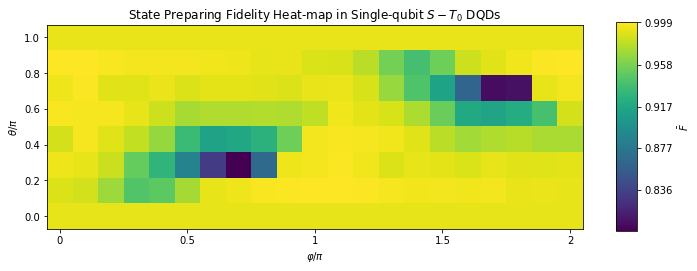

In [5]:
%run src/USP_qd_single_qubit.py 

以上显示的保真度分布热图，也就是原文中的 图2(a)。可见，在此模型下复现结果和原文中一致。

# 2. 复现超导线路模型下，任意单量子比特态之间的互相制备

因只是换了物理模型，主要代码内容和上个模型基本一致。为避免重复，仅对不同之处做以区分性说明。

超导线路模型的哈密顿量为：$$H=-\frac{\hbar}{2}A_z\sigma_z$$
或 $$H=\frac{\hbar}{2}A(\cos{\phi}\sigma_x+\sin{\phi\sigma_y})$$



由于物理限制，只能选择其中一项，分别对应于绕 $z$ 轴方向的旋转，和绕位于 $XY$ 平面内轴的旋转。当相位补偿 $\phi=0$ 时，即为绕 $x$ 轴的旋转，而当 $\phi=\pi/2$ 时，对应绕 $y$ 轴的旋转。

绕 $x$ 和 $y$ 轴的旋转方向可为正，也可为负，而绕 $z$ 轴旋转方向只能为正。

所以定义的动作空间为：

In [ ]:
action_space = np.mat([[1,0,0], #可以选择的动作范围，各列的每项分别代表着 sigma x, y, z 前面的系数。
                       [2,0,0], #每次执行的动作都是单独的绕 x, y, z 轴一定角度的旋转
                       [0,1,0], # x, y 方向的值可以取负，但 z 方向的只能取正值
                       [0,2,0],
                       [0,0,1],
                       [0,0,2],
                       [-1,0,0],
                       [-2,0,0],
                       [0,-1,0],
                       [0,-2,0]])

在执行动作时，哈密顿量代码为：

In [ ]:
H = float(action_space[action,0])*sx/2 + float(action_space[action,1])*sy/2 - float(action_space[action,2])*sz/2

依然可以按照上例方式执行程序：输出平均保真度 F 和 总的运行时间，并将保真度分布热图保存到 src 文件夹中

（图片名为：./src/sj_single_qubit_heat_map.png）。

运行计数为完成目标态制备任务数，达到128时即完成全部计算任务。

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
F_list =  [0.9992626016568953, 0.9995144844019341, 0.9995460533336444, 0.9994487703895798, 0.9994341030357903, 0.9994277361138151, 0.9995065968535353, 0.9995340631758373, 0.999530686497732, 0.999426204281705, 0.9993963640685807, 0.9994114725257038, 0.9995366303277333, 0.9993891174005956, 0.9994904903874451, 0.99942019569232, 0.9993321384538574, 0.9995540107497178, 0.9994607633414887, 0.9995125756924348, 0.9993758571776078, 0.9992989411366318, 0.9994344492569686, 0.9995358246179075, 0.9995188853013945, 0.9994997090832396, 0.9993183356366729, 0.9994400424435175, 0.9994868779795222, 0.999538155

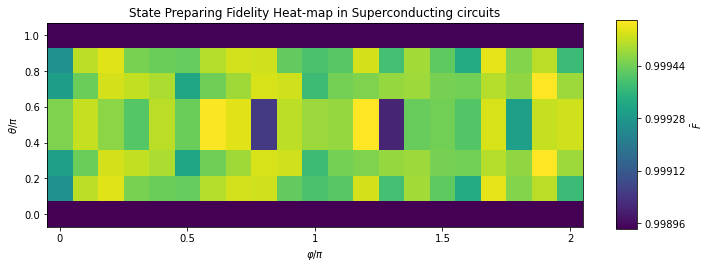

time_cost is:  1373.5808501243591


In [5]:
%run src/USP_sj_single_qubit.py

以上显示的保真度分布热图，也就是原文中的 图2(b)。可见，在此模型下复现结果和原文中一致。

## 论文算法潜在改进方向：

该算法方案采用离散强度和持续时间脉冲控制，这便于在实验上实行，但也造成了量子态最大实现精度不够高的问题（在半导体单-三重态量子比特模型上量子态制备的平均保真度为 0.973）。在后期的改进中可以采用连续脉冲进行控制，以实现更高精度的态制备能力。

## 项目总结

此论文提出的方案可以实现在遵守物理模型限制下找到任意量子态之间相互制备的最佳含时控制方案，属于一类典型的动力学演化分析问题。本项目基于 MindQuantum 量子计算框架对其最核心的结果进行了复现，实现了量子计算中两个重要模型下的单量子比特控制优化任务。复现结果和原论文完美符合，例证了 MindQuantum 框架在量子计算领域中有很强的适用性：并非仅限于量子线路模型，在控制优化等需要动力学演化分析的问题中，该框架依然有着一定的用武之地。

